# Adjusting Foundation Model Behavior with Generation Parameters

You can set a variety of different parameters to control the behavior of Foundation Model API models. This notebook provides a short summary of these generation parameters and their effects on model outputs.

The [REST API Reference](https://docs.databricks.com/en/machine-learning/foundation-models/api-reference.html) provides a list of the parameters accepted by each type of endpoint. We'll go through these in turn.

## Choose when to stop generating with `max_tokens` and `stop`

`max_tokens` sets the number of *new* tokens to generate. It does not count input parameters. So specifying `max_tokens=10` will generate up to 10 new tokens, regardless of the length of the input.

In [1]:
from databricks_genai_inference import ChatCompletion

short_response = ChatCompletion.create(model="llama-2-70b-chat",
                                 messages=[{"role": "system", "content": "You are a helpful assistant."},
                                           {"role": "user","content": "Tell me how MLflow autologging works."}],
                                 max_tokens=10,)
longer_response = ChatCompletion.create(model="llama-2-70b-chat",
                                 messages=[{"role": "system", "content": "You are a helpful assistant."},
                                           {"role": "user","content": "Tell me how MLflow autologging works."}],
                                 max_tokens=128)
print("max_tokens = 10:\n", short_response.message, "\n\n")
print("max_tokens = 128:\n", longer_response.message)

max_tokens = 10:
   MLflow autologging is a feature that 


max_tokens = 128:
   MLflow autologging is a feature that allows you to automatically log and track experiments, runs, and metrics in your machine learning (ML) projects. Here's how it works:

1. Install the MLflow library: To use autologging, you first need to install the MLflow library using pip: `pip install mlflow`.
2. Initialize MLflow: After installing the library, you need to initialize MLflow by running `mlflow init` in your project directory. This command creates a new directory called `.mlflow` in your project directory, which is used to store metadata and logs


The `stop` parameter, on the other hand, tells the model to stop generating new tokens when it encounters one of the strings in a list. For example, in the following example, we use the `stop` command to make sure the model stops generating after it return the code block we're interested in, without providing further explanation.

In [14]:
stop_response = ChatCompletion.create(
    model="llama-2-70b-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Show me how to use awk to print the first and third semicolon-separated fields in file.txt",
        },
    ],
    stop=["file.txt\n```"],
    max_tokens=128,
)

In [15]:
print(stop_response.message)


Sure, I'd be happy to help! Here's an example of how you can use `awk` to print the first and third semicolon-separated fields in `file.txt`:
```
$ awk -F';' '{print $1, $3}' file.txt
```


## Specify the variability of responses with `temperature`, `top_p`, and `top_k`

Foundation Model API responses can generate different responses from the same inputs, enabling a degree of randomness or creativity in the outputs. This variability is controlled by the parameters `temperature`, `top_p`, and `top_k`. Through different combinations of these parameters, we can ensure that the model's responses are entirely deterministic or, on the other hand, are so diverse that they begin to lose coherence.

### Sampling
The process of generating responses involves selecting each subsequent token (which may be a word, a character, or a few characters) based on a probability distribution that considers the sequence of tokens generated so far. Unlike deterministic processes, where a given input always produces the same output, this [sampling](https://huggingface.co/blog/how-to-generate) process allows for different outputs on the same input, enhancing the model's flexibility and utility in generating diverse content.

### Temperature
The `temperature` parameter determines the shape of the probability distribution based on which the tokens are drawn. A low temperature (close to 0) will place much more of the probability on the top candidates, which leads to more predictable responses. A temperature of 0 will result in fully deterministic responses. Higher temperatures (close to 2) will "flatten" the distribution, increasing the likelihood that lower probability tokens will be selected. This increases the diversity and creativity of the responses but it can also result in less coherent responses.

### `top_p` and `top_k`
Both `top_p` (nucleus sampling) and `top_k` limit the pool of candidate tokens considered for the next token in the sequence, but they do so differently:
- `top_k` limits the selection to the `k` most likely next tokens.
- `top_p` dynamically selects the smallest set of tokens whose cumulative probability exceeds the threshold `p`, focusing on a "nucleus" of high-probability options. This method adapts to the context's uncertainty level, potentially considering more or fewer tokens based on their probability distribution.

Let's consider some scenarios. In each case, we'll generate three different completions for the prompt `The dog went to the`. We will also examine the distribution of the first token across 100 responses.

1. `temperature` = 0
The model will be deterministic: it will always pick the most likely next token. It doesn't matter if `top_p` or `top_k` are higher because all of the probability is on the single most likely next token.

In [18]:
from databricks_genai_inference import Completion

def generate(max_tokens = 64, temperature=0, top_k=None, top_p=None):
    response = Completion.create(
        model="mpt-30b-instruct",
        prompt="The dog went to the",
        max_tokens=max_tokens,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        use_raw_prompt=True,)
    return response.text

for _ in range(3):
    print(generate(temperature=0, top_k=1))

[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']
[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']
[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']


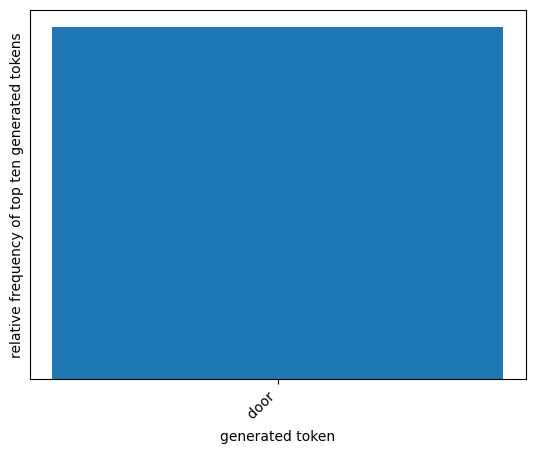

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
import time


def plot_distribution(n=100, temperature=1, top_k=None, top_p=None):
    x = []
    for _ in range(n):
        x.extend(generate(max_tokens=1, temperature=temperature, top_k=top_k, top_p=top_p))
        time.sleep(0.3)

    word_counts = Counter(x)
    top_ten = word_counts.most_common(10)

    plt.figure(facecolor="white")
    plt.bar(*zip(*top_ten))
    plt.xticks(rotation=45, ha="right")
    plt.yticks([])
    plt.xlabel("generated token")
    plt.ylabel("relative frequency of top ten generated tokens")
    plt.show()

plot_distribution(temperature=0)

2. `temperature` = 2 and `top_k` = 1

The model will still be deterministic. Even though the temperature is high, we are still only considering the most probable next token.

In [6]:
for _ in range(3):
    print(generate(temperature=2, top_k=1))


[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']
[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']
[' door and barked.\n\n"What is it, boy?"\n\nThe dog barked again.\n\n"All right, I\'m coming."\n\nHe opened the door and the dog dashed out. A moment later there was a loud crash from the direction of the kitchen.\n\n"Oh,']


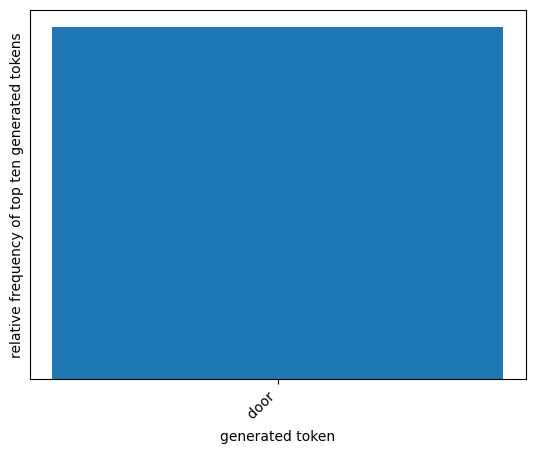

In [7]:
plot_distribution(temperature=2, top_k=1)

3. `temperature` = 2 and `top_k` = 5

The model will not be deterministic. At each step, the model will consider the `5` most probable next tokens, weighted by their respective probabilities.

In [8]:
for _ in range(3):
    print(generate(temperature=2, top_k=5))

[" front door and waited patiently.\n\nThe dog's name is Shadow and she has a big heart.\n\nThe dog was panting from the heat.\n\nThe doctor told me that the medicine I need can only be given by injection.\n\nI'm not sure how to give an injection. I've"]
[' door of the cage, and, after a momentary pause, as much\nas to say, "Are you sure you are right? It\'s a pity to disturb anybody\nsleeping," gave a gentle little tap with his nose.\n\n"Oh, I say!" cried the young officer, starting up,']
[" water's side\nAnd looked at the strange sight;\nHe saw his own tail floating there, --\nHe barked with joyful fright."]


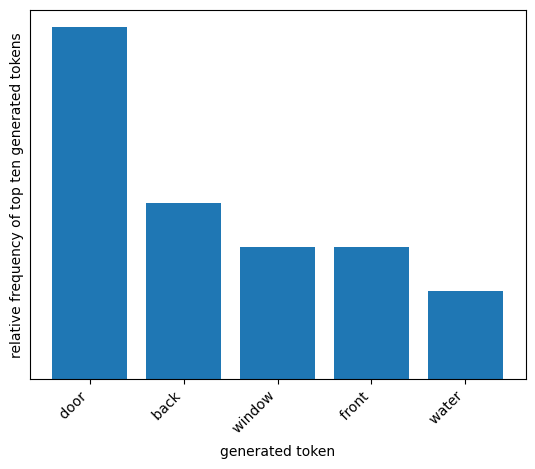

In [9]:
plot_distribution(temperature=2, top_k=5)

4. `temperature` = 1.5 and `top_p` = 0.5

The model will not be deterministic. At each step, the model will consider as many tokens as it takes to account for the top half of candidate tokens by probability.

Because we specified a relatively high `temperature`, the probability is spread out across many tokens and not concentrated on the top few tokens. Combining a high `temperature` with a high `top_p` may result in responses that start to lose coherence.

In [10]:
for _ in range(3):
    print(generate(temperature=1.5, top_p=0.5))

[' hospital where she was x-rayed, and thankfully the x-rays did not show any broken bones.\nThe lump on the side of her head was thought to be caused by a piece of skin from where she had been fighting with another dog.\nThe vets decided to keep her in overnight for observation']
[' pigsty and found some water in a\n     pitcher and some turnips in a bag. After this he hunted about the\n     yard, and found a string of onions hanging up to dry. He took\n     them all to Bale Boese, who placed them before his master. When\n     the']
[' back door and waited, the chains rattling as he paced back and forth. Something about the noise must have woken Jonathan, because a light came on upstairs and a shadow passed behind the curtained window. Ginny could hear him moving around up there. She imagined him looking out the window, but it was']


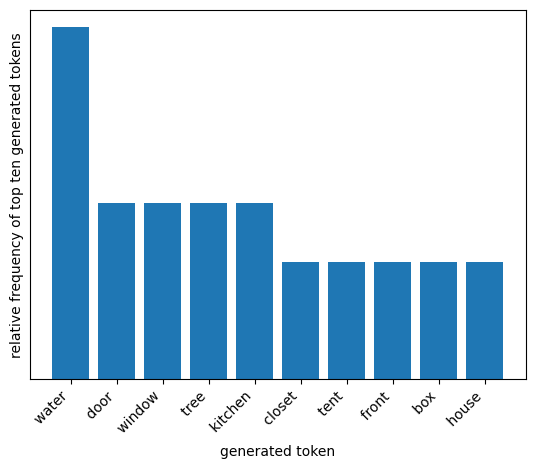

In [11]:
plot_distribution(temperature=1.5, top_p=0.5)

5. `temperature` = 1 and `top_p` = 0.5

Now we lower the `temperature` while keeping the `top_p` at 0.5. The model will still generate diverse responses, but much more of the probability mass will be concentrated on the top few most likely tokens, so the responses will be more coherent. We see this reflected in the distribution of the first token.

In [19]:
for _ in range(3):
    print(generate(temperature=1, top_p=0.5))

[' fridge and started barking at it.\n\n"I don\'t think it\'s going to open," I said.\n\n"It\'s not," said Nick. "It\'s a freezer."\n\n"I know that," I said. "I was making a joke."\n\n"I don\'t think']
[' bed and lay down.\n\n"You can\'t stay here," I said. "This isn\'t your home."\n\nThe dog didn\'t move.\n\n"I\'ll take you out," I said. "But you have to come with me."\n\nThe dog didn\'t move.\n\nI']
[' door and barked.\n\n"That\'s not a dog," I said. "That\'s a wolf."\n\n"Oh," said Marjorie. "I thought it was a dog."\n\n"It\'s a wolf," I said. "It\'s not housebroken."\n\n"Oh,"']


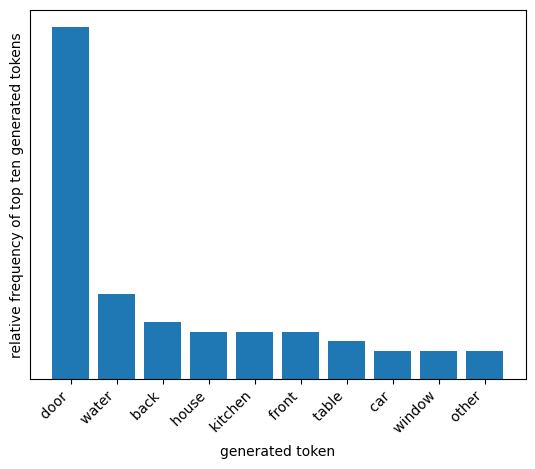

In [13]:
plot_distribution(temperature=1, top_p=0.5)

### Next steps
In summary: lower temperatures concentrate more of the probability on the top candidate tokens, while higher temperatures flatten the distribution and result in more diverse responses. Higher values of top_k or top_p consider a wider range of candidate tokens, while lower values restrict the range of candidate tokens.

We only explored a few combinations of these parameters. Feel free to download this notebook and experiment with different combinations using the `generate` and `plot_distribution` functions from this notebook.

## Conclusion
You now understand how to use generation parameters to control when the model stops generating and how diverse and creative the responses are. You can use the functions defined in this notebook to experiment with different combinations of temperature, top_p, and top_k to explore the effect of these parameters on the model's responses.